# Image Classification: Male vs. Female Using CNN in TensorFlow

## Download and Extract Dataset from GitHub

In [1]:
# Download the dataset zip file from the updated GitHub repository
!wget --no-check-certificate \
  https://github.com/radityadhaaa/Image-Classification--Male-vs.-Female/raw/main/dataset_image.zip \
  -O /tmp/Dataset_Gambar.zip

--2024-11-12 17:36:16--  https://github.com/radityadhaaa/Image-Classification--Male-vs.-Female/raw/main/dataset_image.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/radityadhaaa/Image-Classification--Male-vs.-Female/main/dataset_image.zip [following]
--2024-11-12 17:36:16--  https://raw.githubusercontent.com/radityadhaaa/Image-Classification--Male-vs.-Female/main/dataset_image.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61587174 (59M) [application/zip]
Saving to: ‘/tmp/Dataset_Gambar.zip’

/tmp/Dataset_Gambar 100%[===================>]  58.73M   118MB/s    in 0.5s    

2024-11-12 17

This downloads the dataset from GitHub to a local temporary file location.

In [2]:
# Import necessary libraries for file manipulation and image processing
from google.colab import files
import zipfile
import os
import pathlib
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, Sequential
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

Essential libraries for data manipulation, deep learning, and image processing are imported here.

In [3]:
# Define the local path to the downloaded zip file
local_zip = '/tmp/Dataset_Gambar.zip'

# Open and extract the zip file
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall('/content')

Here, the downloaded zip file is extracted into a folder (/content) on the local file system.

In [4]:
# Set up the dataset directory for easier reference
data_dir = pathlib.Path("/content/dataset_image")

This sets up a convenient path reference to the dataset directory.

## Dataset Inspection and Counting

In [5]:
# Count the number of JPEG files in the dataset
image_count = len(list(data_dir.glob('*/*.jpeg')))
print("Total Images:", image_count)

Total Images: 734


Counts the total number of images in the dataset by looking for all .jpeg files across all subfolders.

In [6]:
# List the classes and count the instances in each class
list_dir = [os.path.basename(x) for x in data_dir.iterdir() if x.is_dir()]
print("Number of Classes: {} ".format(len(list_dir)))
print("Number of Instances per Class:")
for class_name in list_dir:
    print(f"{class_name} = {len(list(data_dir.glob(f'{class_name}/*.jpeg')))}")

Number of Classes: 2 
Number of Instances per Class:
Laki - Laki = 415
Perempuan = 319


Lists each class (subfolder) and counts the number of images in each class, helping verify data structure.

## Display Sample Images

In [7]:
# Display sample images from 'Laki-Laki' and 'Perempuan' classes
laki_laki = list(data_dir.glob('Laki - Laki/*'))
perempuan = list(data_dir.glob('Perempuan/*'))
Image.open(str(laki_laki[1])).show()  # Display a male sample image
Image.open(str(perempuan[1])).show()  # Display a female sample image

Displays one sample image from each class (Male and Female) to visually verify the dataset content.

## Load Dataset for Training and Validation

In [8]:
# Define batch size and image dimensions
batch_size = 32
img_height = 180
img_width = 180

Defines the image dimensions and batch size for training.

In [9]:
# Create training dataset with a 60/40 train/validation split
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.4,
    subset="training",
    seed=111,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 734 files belonging to 2 classes.
Using 441 files for training.


Creates the training dataset by splitting 60% of the data for training, using specified dimensions.

In [10]:
# Create validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.4,
    subset="validation",
    seed=111,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 734 files belonging to 2 classes.
Using 293 files for validation.


Creates a validation dataset using the remaining 40% of the data.

In [11]:
# Retrieve class names from the training dataset
class_names = train_ds.class_names
print("Class Names:", class_names)

Class Names: ['Laki - Laki', 'Perempuan']


Retrieve class names from the training dataset

## Visualize Training Images

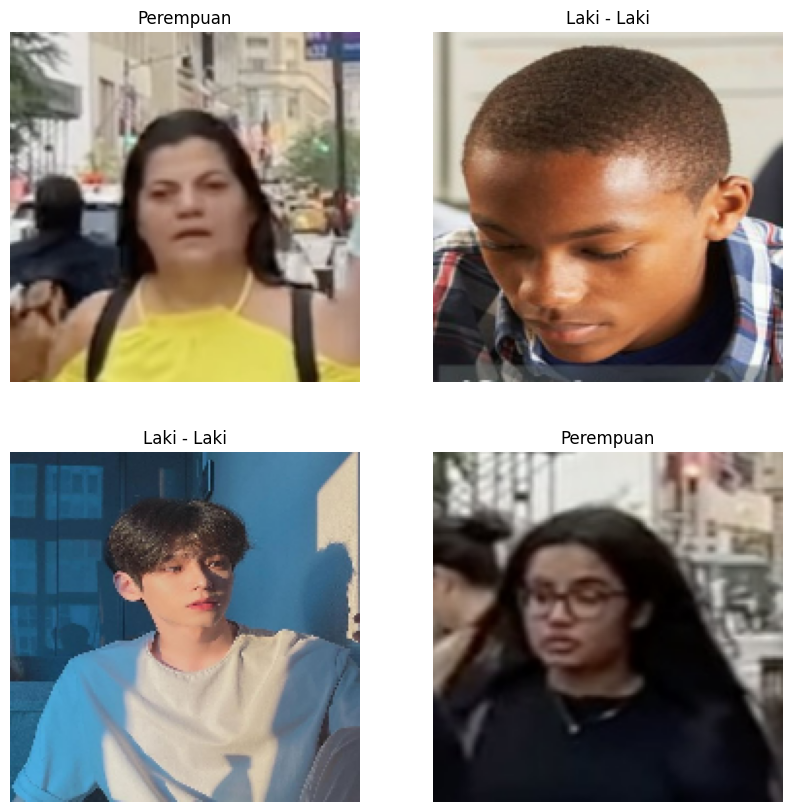

In [12]:
# Display a few images from the training dataset with class names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

Displays four sample images from the training dataset with their respective class names to verify loading.

## Dataset Optimization

In [13]:
# Constants to optimize dataset performance
AUTOTUNE = tf.data.AUTOTUNE

# Optimize training dataset with caching, shuffling, and prefetching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Optimizes dataset performance by caching, shuffling, and prefetching data for faster access during training.

## Normalize Pixel Values

In [14]:
# Define a normalization layer to scale RGB values to 0-1
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

Normalizes pixel values to a [0, 1] range, improving model convergence.

## Define CNN Model

In [15]:
# Define the CNN model architecture
num_classes = len(class_names)
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      15,859,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,953,473 (60.86 MB)

 Trainable params: 15,953,473 (60.86 MB)

 Non-trainable params: 0 (0.00 B)

Defines a CNN architecture with convolutional and max pooling layers for feature extraction and a dense layer for classification.

In [16]:
# Compile the model with RMSprop optimizer and binary cross-entropy loss
model.compile(
    optimizer='RMSprop',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

Compiles the model with the RMSprop optimizer and binary cross-entropy loss for binary classification.

## Train the Model

In [17]:
# Set the number of training epochs
epochs = 15

# Train the model and validate it on validation data
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 492ms/step - accuracy: 0.4778 - loss: 1.6434 - val_accuracy: 0.5973 - val_loss: 0.6759
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5279 - loss: 0.6957 - val_accuracy: 0.5973 - val_loss: 0.6811
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5832 - loss: 0.6935 - val_accuracy: 0.5973 - val_loss: 0.6729
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5915 - loss: 0.6711 - val_accuracy: 0.4027 - val_loss: 0.7961
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5511 - loss: 0.7003 - val_accuracy: 0.5563 - val_loss: 0.6832
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6149 - loss: 0.6746 - val_accuracy: 0.6041 - val_loss: 0.6395
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6941 - loss: 0.6186 - val_accuracy: 0.6724 - val_loss: 0.6006
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6937 - loss: 0.5902 - val_accuracy: 0.6758 -

Trains the model with 15 epochs, tracking accuracy and loss for both training and validation data.

## Plot Training and Validation Accuracy and Loss

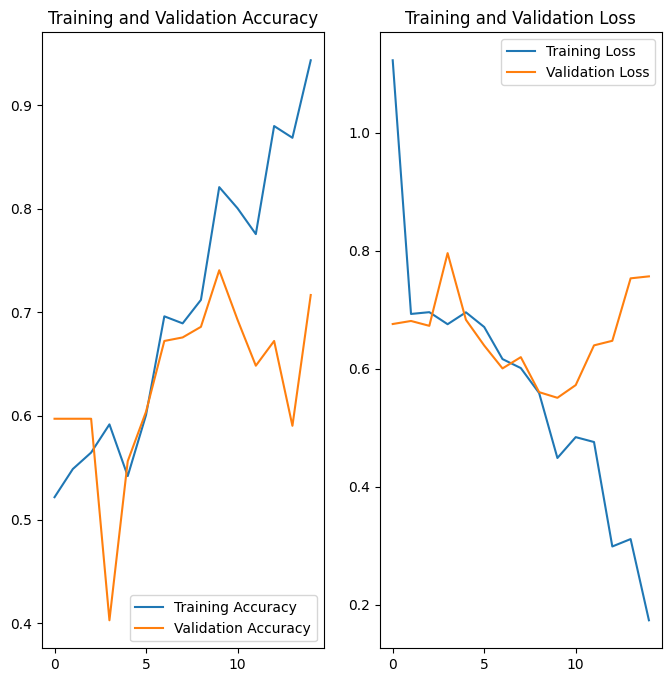

In [18]:
# Retrieve accuracy and loss values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Define the range of epochs for the x-axis
epochs_range = range(len(acc))  # or range(epochs) if you already defined 'epochs'

# Plot accuracy and loss
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


Displays plots of training and validation accuracy and loss to assess model performance.

## Data Augmentation for Enhanced Model Performance

In [19]:
# Define a data augmentation pipeline
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
    ]
)

Applies data augmentation techniques to improve the model’s generalization ability.

## Define and Train Model with Data Augmentation

In [20]:
# Re-define the CNN model with data augmentation
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

Adds data augmentation to the CNN model to increase the variety of training data and reduce overfitting.

## Load and Predict New Images

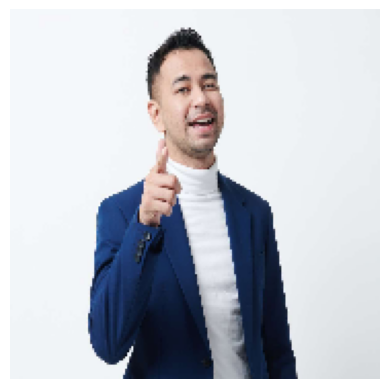

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
The image is classified as 'Laki-Laki'.


In [23]:
# Predict the class for each uploaded image
for fn in uploaded.keys():
    # Load and display the image
    img = tf.keras.utils.load_img(fn, target_size=(img_height, img_width))
    plt.imshow(img)
    plt.axis("off")  # Hide axis for better display
    plt.show()

    # Preprocess the image
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # Make predictions using the model
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    predicted_label = 0 if classes < 0.5 else 1

    # Display text-based classification result
    category = "Laki-Laki" if predicted_label == 0 else "Perempuan"
    confidence = 100 * np.max(classes) if predicted_label == 1 else 100 * (1 - np.max(classes))
    print(f"The image is classified as '{category}'.")

## Conclusion
The CNN model demonstrates the ability to classify images based on visual patterns. By using data augmentation and optimizing the dataset pipeline, we improve the model's performance and robustness. The model’s accuracy and loss plots provide insights into the training process, helping to adjust parameters and model architecture for future improvements.